**1. SETTING UP THE COLAB ENVIRONMENT**

---



In [1]:
# INSTALLING ALL IMPORTANT & REQUIRED LIBRARIES

!pip install nibabel
import nibabel as nib # To manipulate & work on NIfTI files
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.5 MB/s eta 0:00:00


**2. DOWNLOADING OUR BRATS2020 DATASET**

---



In [2]:
# CREATED API TOKEN ON KAGGLE AND DOWNLOADED THE JSON FILE
# UPLOADING THE DOWNLOADED JSON API FILE HERE --

from google.colab import files
files.upload()


Saving kaggle-2.json to kaggle-2.json


{'kaggle-2.json': b'{"username":"abhinavgahoi","key":"b436f114ac3a5b4e040097aafffe5b73"}'}

In [3]:
# SETTING PERMISSION AND DIRECTORY OF THE JSON FILE

import os
import json

#Creating the Kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)


os.rename('kaggle-2.json', '/root/.kaggle/kaggle.json')  # Rename the file

#Setting permissions for the kaggle.json file
os.chmod('/root/.kaggle/kaggle.json', 0o600)

In [4]:
# INSTALLING KAGGLE PACKAGE

!pip install kaggle

DATASET LINK - [BRATS2020](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation)

In [5]:
# DOWNLOADING THE DATASET

!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [00:16<00:00, 272MB/s]
100% 4.16G/4.16G [00:16<00:00, 265MB/s]


In [6]:
# UNZIPPING THE DATASET

import zipfile

# Defining path to the zip file
path_to_zip_file = "brats20-dataset-training-validation.zip"

# Opening zip file in read mode
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    # Extracting contents of the zip file
    zip_ref.extractall("brats20-dataset-training-validation")


In [7]:
# RENAMING UNEVEN FILES

# Path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

The file has been successfully renamed


**3. DATA EXPLORATION**

---


In our dataset each sample has -

1.   Four types of MRI Scans or We can say modalities - T1, T1ce, T2, T2(FLAIR)
2.   Ground Truth Segmentation manually done by experts



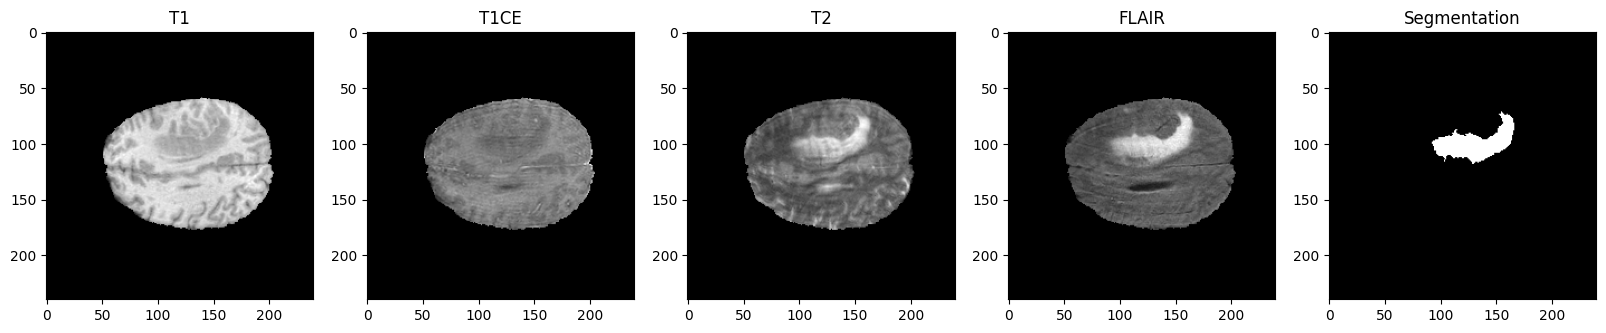

In [8]:
# TAKING OVERVIEW OF SAMPLE IMAGES OF FIRST PATIENT

# Path to first patient data
sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Loading the 4 MRI modalities & the ground truth segmentation image objects
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Converting the loaded image objects into numpy arrays for visualising
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Setting slice for visualisation
slice_nb = 100

# Create a figure with 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

MODALITIES :



1.   T1 - Shows the structure of diff. kinds of tissues in brain, used for identifying tumors & cysts.
2.   T1ce - T1 images with contrast that enhance the visibilty of abnormalities.
3.   T2 - Shows the fluid content of diff. tissues of the brain.
4.   FLAIR - Used to suppress the fluid content & to identify lessions in white matter of the brain

Here we are using T1CE & T2-FLAIR modalitity. We exclused T1 as we have improved image T1CE and we exclude T2 as fluid content disrupts our prediction, in FLAIR these fluids are removed and they highlight the affected region more effectively.






In [9]:
# UNDERSTANDING THE IMAGE FORMAT (Scans are NIfTI files (Neuroimaging Informatics Technology Initiative))
# NIfTI IMAGE IS A DIGITAL REPRESENTATION OF A 3D OBJECT

# Shape of the NumPy array of Modalitiy Data - (DEPTH, HEIGHT, WIDTH)
print(t1_data.shape)

# Shape of the NumPy array of Segmentation Data - (DEPTH, HEIGHT, WIDTH)
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


In Medical imaging a 3D images have three dimensions -


1.   AXIAL PLANE - Divides the body into top and bottom sections
2.   CORONAL PLANE - Divides the body into front and back sections
3.   SAGITTAL PLANE - Divides the body into left and right sections


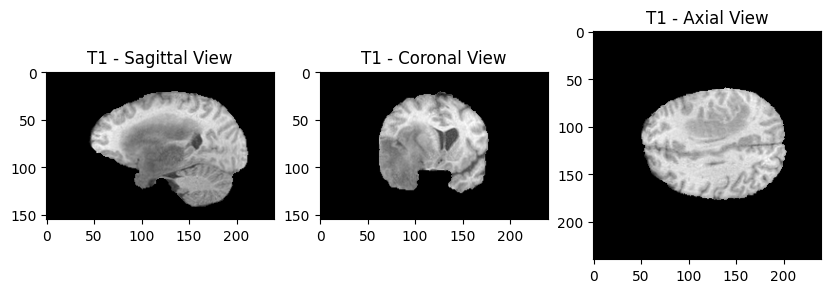

In [10]:
# PLOTTING A SPECIFIC MODALITIY (EXAMPLE - T1) THROUGH ALL PLANES

slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

HERE WE WILL UNDERSTAND WHY WE CHOOSE SLICE AS 100 BY VISUALISING ALL SLICES OF THE IMAGE

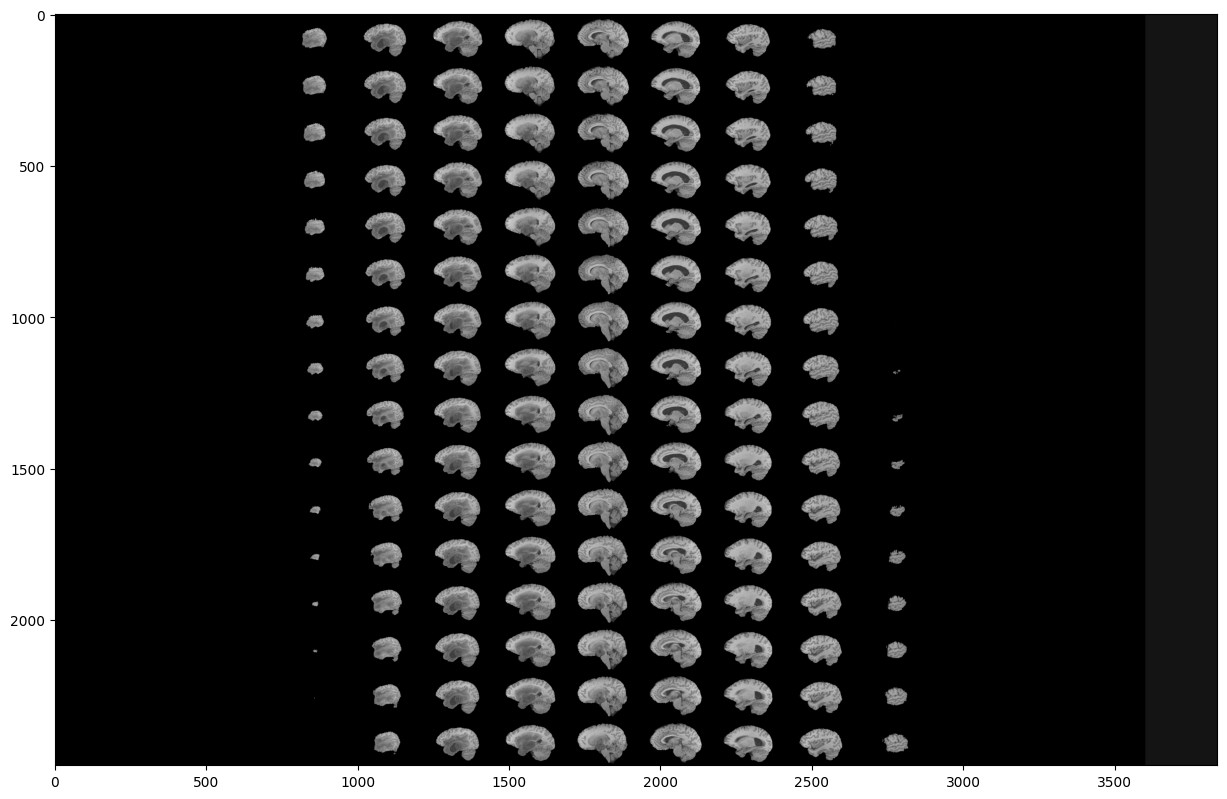

In [11]:
# VISUALISING ALL SLICES OF T1 USING MONTAGE FUNC.

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

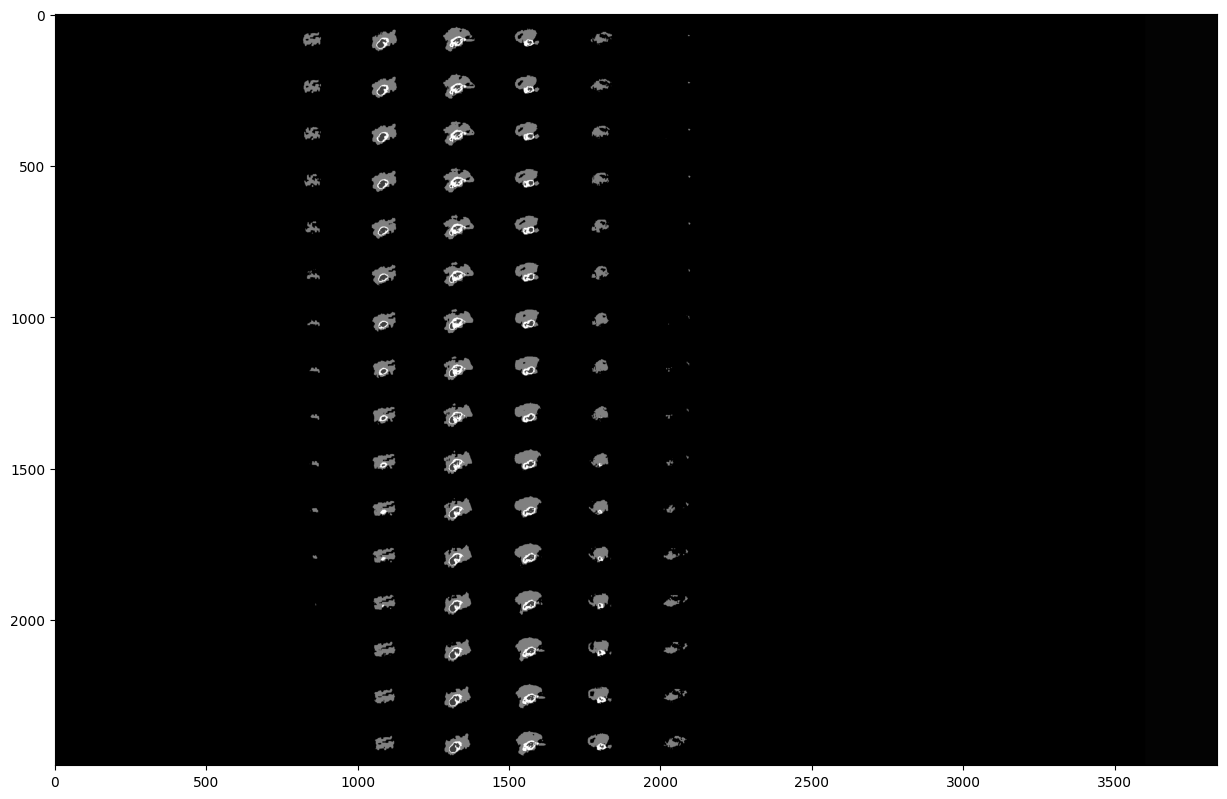

In [12]:
# VISUALISING ALL SLICES OF SEGMENTATION DATA USING MONTAGE FUNC.

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')


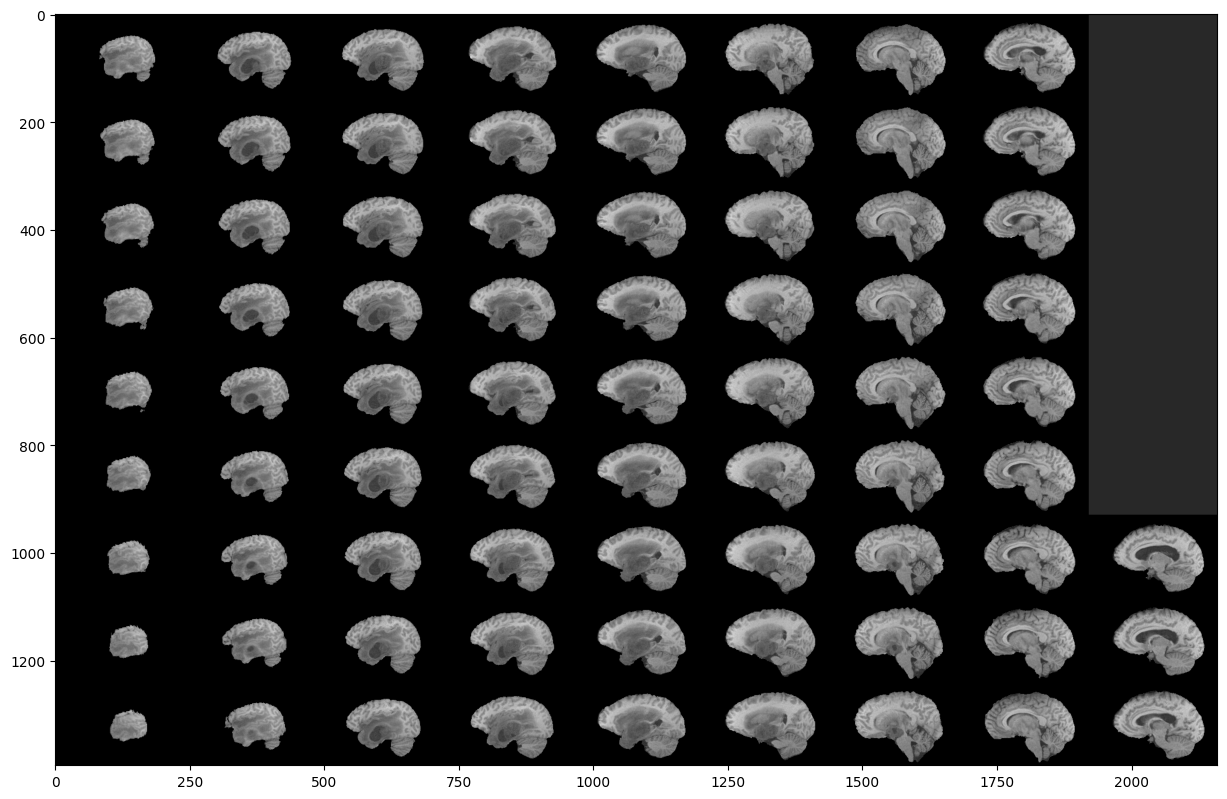

In [13]:
# WE CHOOSED A RANGE OF 60 - 135 OF SLICES

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')


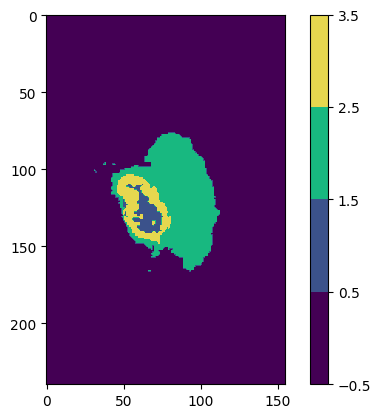

In [14]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()


In [15]:
# FINDS ALL UNIQUE LABLES IN THE WHOLE SEGMENTATION DATA

data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


We have 4 possible values in the segmentation files, these 4 values will form our 4 classes and they correspond to -


1.   0 : No Tumor (NT) which means Healthy Zone or Background
2.   1 : Necrotic and Non-Enhancing Tumor (NCR + NET)
3.   2 : Peritumoral Edema (ED)
4.   4 : Enhancing Tumor (ET)



In [16]:
# These are the count of each unique value or label in a certain segmentation data

values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


**NORMALISATION**


As we noticed a lot of annonated data is marked to class 0 (Background or Useless Info)

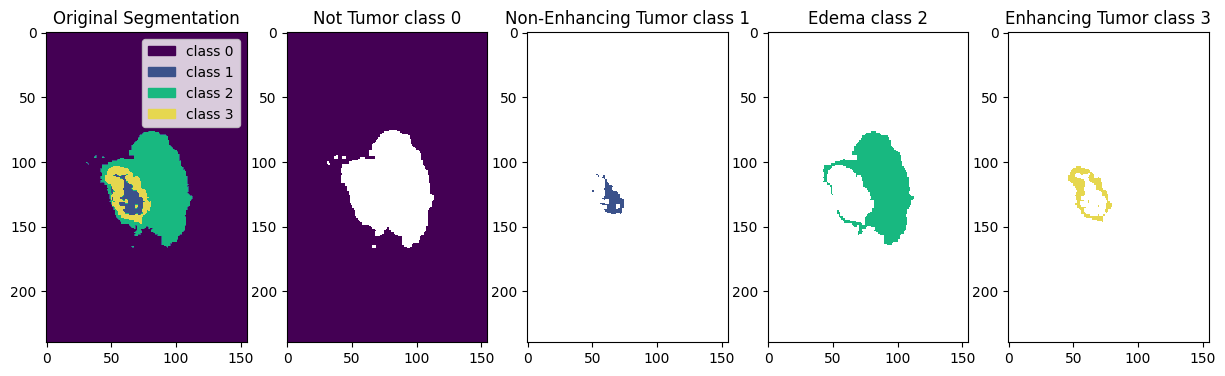

In [17]:
# We will delete out class 0 from the image and preserve other classes

# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define reference for the plot
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [18]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

**4. SPILTTING THE DATASET**

---



In [19]:
# COUNTING ITEMS

# Path of our BraTS2020 Data
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [20]:
# REMOVING UNRELATED ITEMS OR SAMPLES

samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [21]:
# Split the dataset into traininig and validation sets (80% - Training , 20% - Validation)
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the training set into the real training set and a test set (85% - Training , 15% - Testing)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


**DATA GENERATION & RESIZING**

In [51]:
# Batches generation for large datasets & make training efficient, resizes images to a uniform size
IMG_SIZE = 128

# Initialization of data generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True, **kwargs): # Add **kwargs here
        super().__init__(**kwargs) # Call superclass constructor
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

# Calculates the no. of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

# Generates one batch of data
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

# Method to Shuffle Data
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# Method to Generate Data
    def __data_generation(self, Batch_ids):
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'

            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Convert class 4 to class 3 & one-hot encoded format and resize
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

**U-NET ARCHITECTURE**

- DROPOUT FOR REGULARIZATION


In [52]:
# RELU FOR NON-LINEARITY

def build_unet(inputs, ker_init, dropout):
    # Encoder - extracts basic features and reduces the spatial dimensions
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)

    #2ND CONVOLUTION - extract more complex features
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)

    #3RD CONVOLUTION - extract more hidden features
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #4TH CONVOLUTION - extracts very high level features
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #BOTTLENECK LAYER - Captures the most hidden features
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    #DECODER - reconstructs the spatial dimensions
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    # FINAL LAYER - Produces the segmentation map with class probabilities.
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

**PERFORMANCE**


- Dice Coefficient: Measures the overlap between the predicted and true masks. It is useful for evaluating how well the model captures the shape and location of the segmented regions.

- Precision: Indicates how many of the predicted positives are true positives. It reflects the accuracy of the positive predictions.

- Sensitivity (Recall): Reflects how well the model detects positive cases out of all actual positives.

- Specificity: Measures how well the model correctly identifies negatives out of all actual negatives.

In [53]:
# Compute metric between the predicted segmentation and the ground truth

import tensorflow.keras.backend as K
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [54]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

Callbacks can help in monitoring the training process, saving the model, adjusting learning rates, and logging training details

In [55]:
callbacks = [#Reduces the learning rate when a monitored metric has stopped improving
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.weights.h5', # Changed the file extension
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

**TRAINING OUR MODEL OVER 35 EPOCH ITERATIONS**

In [56]:

model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/35
250/250 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.9779 - mean_io_u_4: 0.3757 - dice_coef: 0.2663 - precision: 0.9761 - sensitivity: 0.9622 - specificity: 0.9937
Epoch 1: val_loss improved from inf to 0.07951, saving model to model_.01-0.079512.weights.h5
250/250 [==============================] - 1132s 5s/step - loss: 0.2773 - accuracy: 0.9779 - mean_io_u_4: 0.3757 - dice_coef: 0.2663 - precision: 0.9761 - sensitivity: 0.9622 - specificity: 0.9937 - val_loss: 0.0795 - val_accuracy: 0.9796 - val_mean_io_u_4: 0.3757 - val_dice_coef: 0.2848 - val_precision: 0.9793 - val_sensitivity: 0.9793 - val_specificity: 0.9931 - lr: 0.0010
Epoch 2/35
250/250 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9811 - mean_io_u_4: 0.3757 - dice_coef: 0.2802 - precision: 0.9815 - sensitivity: 0.9794 - specificity: 0.9939
Epoch 2: val_loss improved from 0.07951 to 0.07515, saving model to model_.02-0.075155.weights.h5
250/250 [=================

**METRICAL ANALYSIS OF THE MODEL**

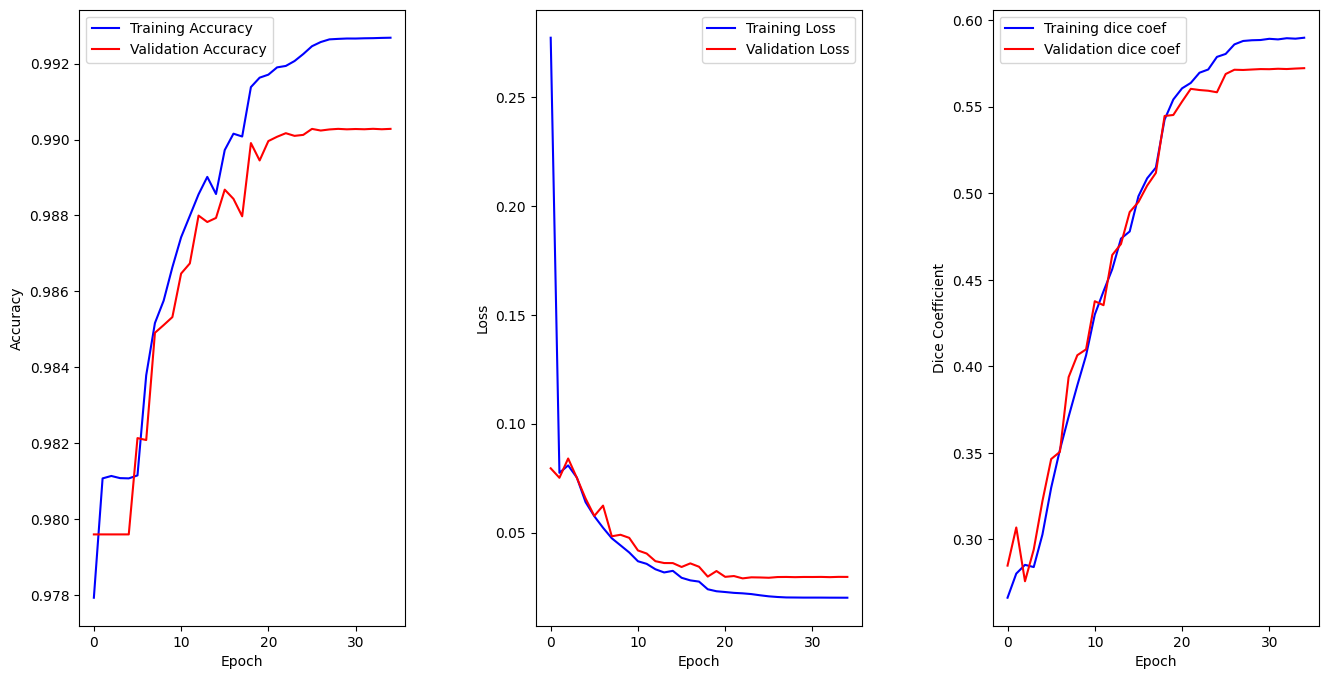

In [77]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()


# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [78]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)


In [79]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 1s 187ms/step
Patient number:  BraTS20_Training_133


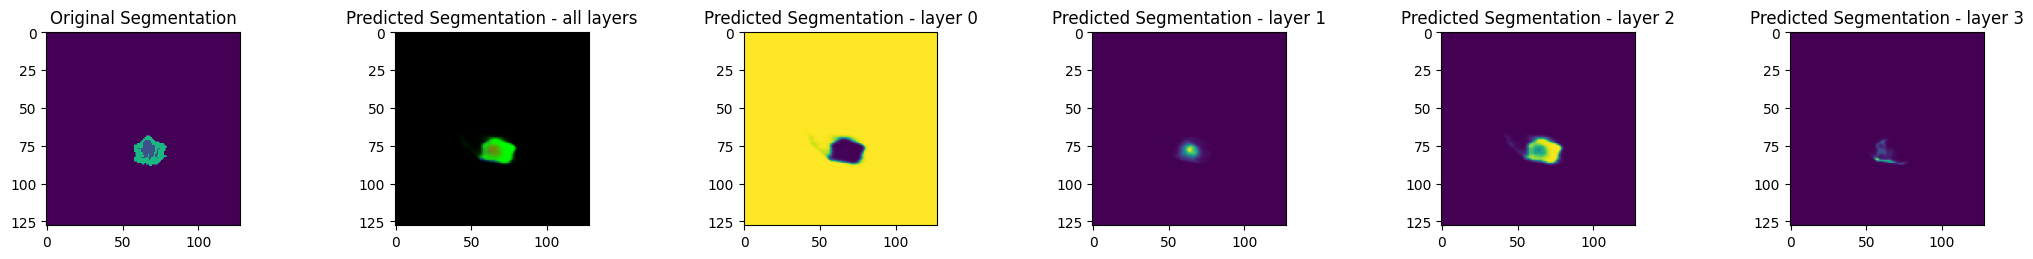

In [65]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 [==============================] - 1s 188ms/step
Patient number:  BraTS20_Training_120


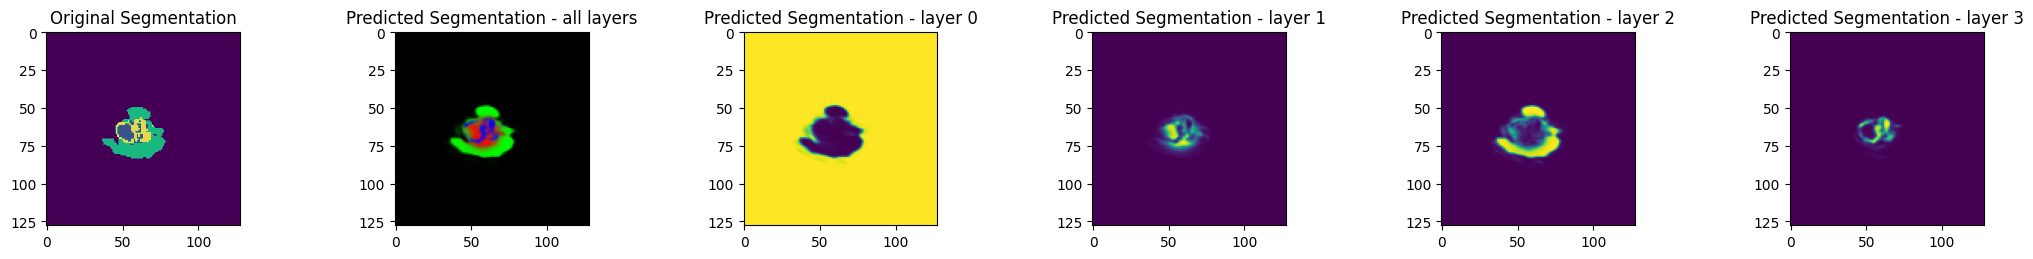

In [72]:
show_predicted_segmentations(samples_test, 50, cmap, norm)


3/3 [==============================] - 1s 185ms/step
Patient number:  BraTS20_Training_246


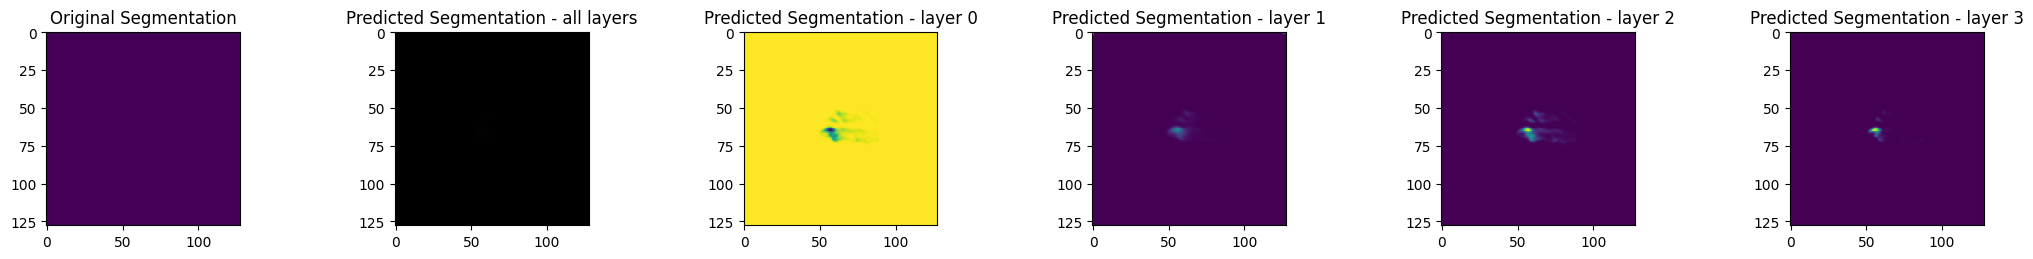

In [73]:
show_predicted_segmentations(samples_test, 70, cmap, norm)


3/3 [==============================] - 1s 190ms/step
Patient number:  BraTS20_Training_208


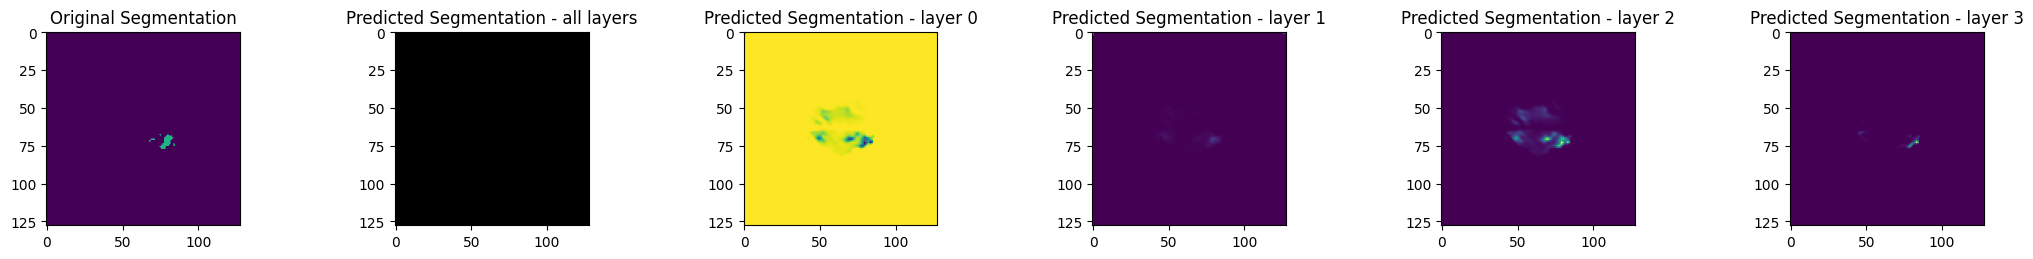

In [74]:
show_predicted_segmentations(samples_test, 70, cmap, norm)


3/3 [==============================] - 1s 188ms/step
Patient number:  BraTS20_Training_221


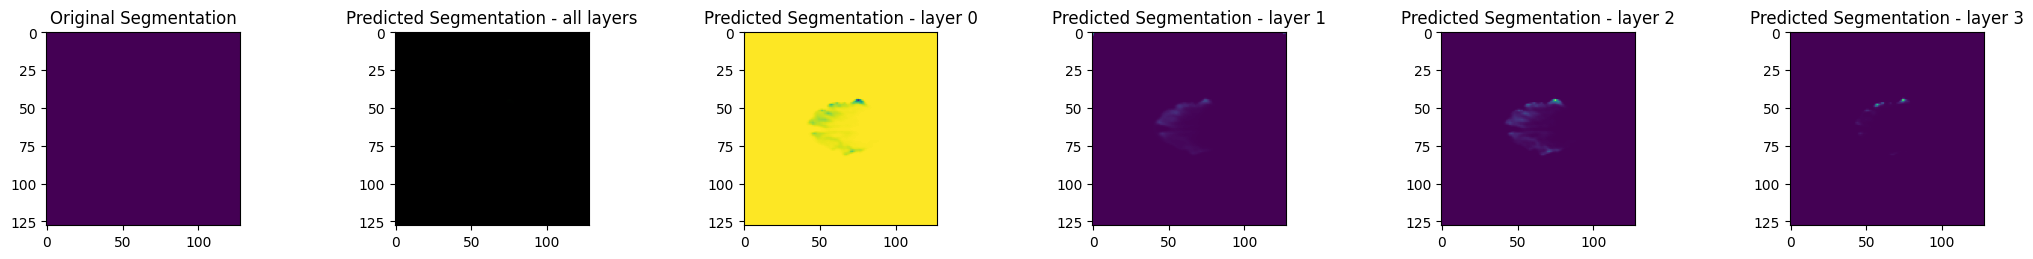

In [75]:
show_predicted_segmentations(samples_test, 70, cmap, norm)


In [66]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):

    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3

    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan

    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4]

    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 1s 195ms/step
Patient number:  BraTS20_Training_266


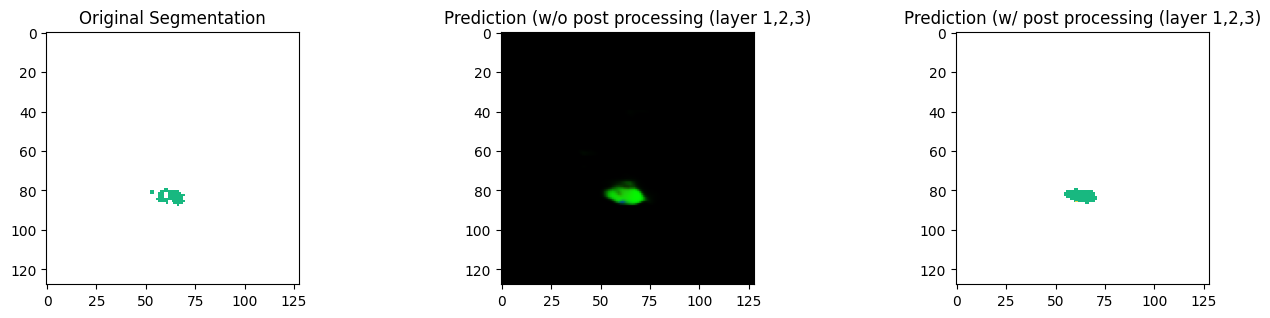

In [67]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 1s 192ms/step
Patient number:  BraTS20_Training_051


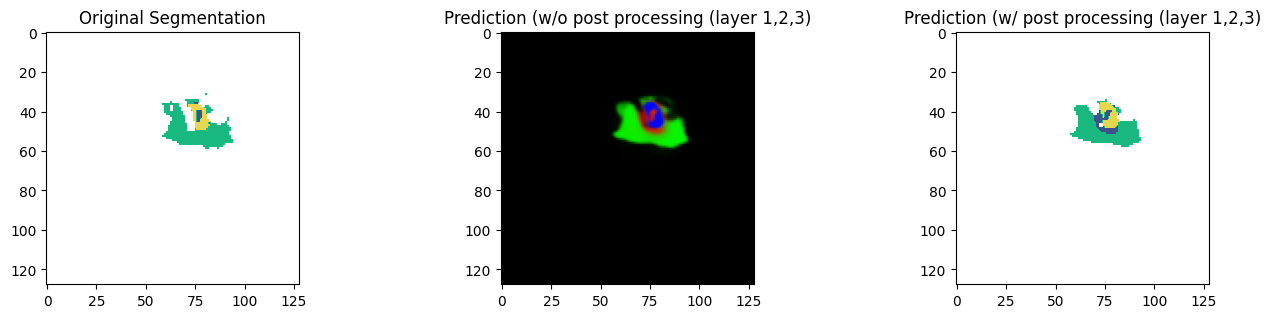

In [68]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 [==============================] - 1s 178ms/step
Patient number:  BraTS20_Training_266


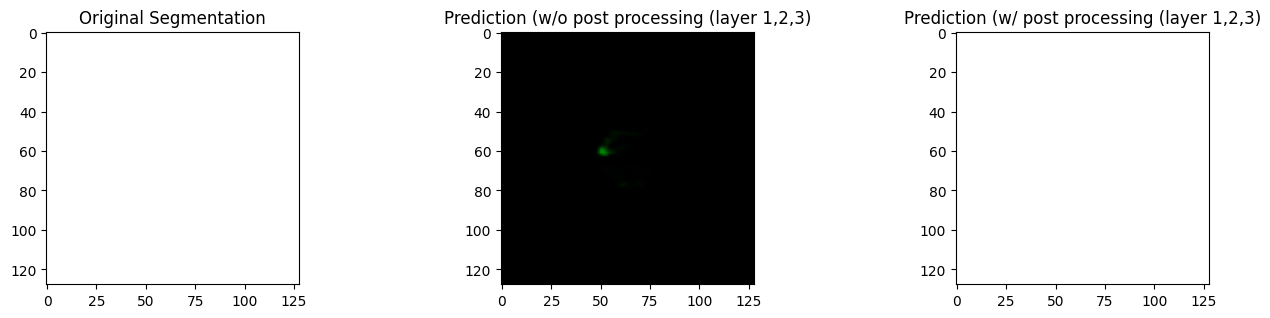

In [69]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 1s 179ms/step
Patient number:  BraTS20_Training_051


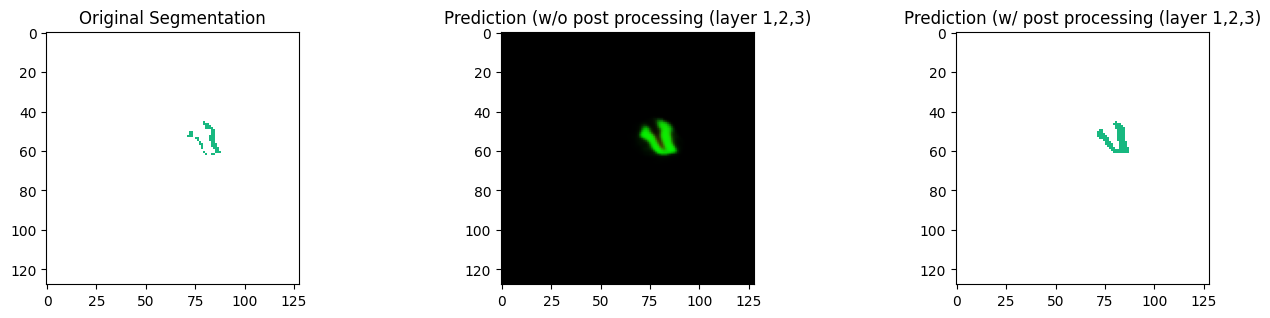

In [70]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 1s 196ms/step
Patient number:  BraTS20_Training_274


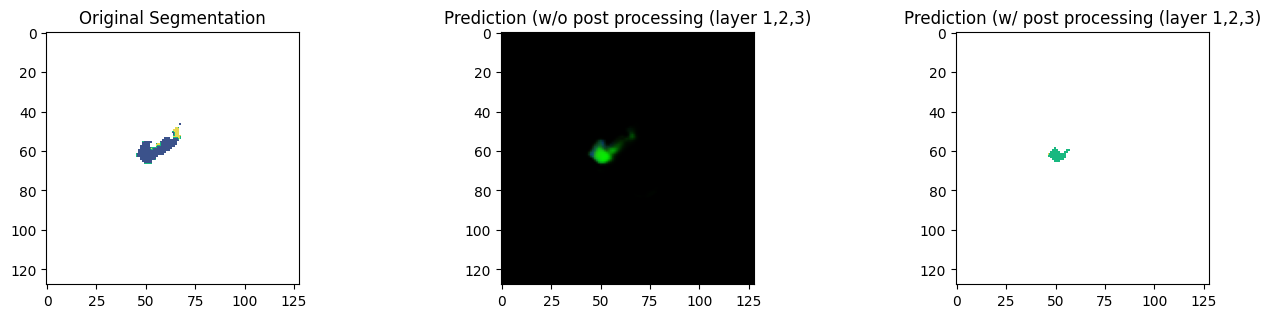

In [71]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)


In [76]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 38s 830ms/step - loss: 0.0231 - accuracy: 0.9924 - mean_io_u_4: 0.3756 - dice_coef: 0.5816 - precision: 0.9934 - sensitivity: 0.9905 - specificity: 0.9977

Model evaluation on the test set:
Loss : 0.0231
Accuracy : 0.9924
MeanIOU : 0.3756
Dice coefficient : 0.5816
Precision : 0.9934
Sensitivity : 0.9905
Specificity : 0.9977
